In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Arial"
import scipy.interpolate as interp
import time
from tqdm import tqdm
from IPython import display
import scipy.optimize as opt

import tensorflow as tf
print(tf. __version__)

import matplotlib
cmap_NN = matplotlib.colormaps['Reds']
cmap_RMSA = matplotlib.colormaps['Blues']

2.10.0


## Load model

In [2]:
from SQ_NN import SQ_NN, SQ_NN_tf, Decoder_aug, sm_GP
from RMSA import RMSA
q_rs = (np.arange(80)+1)*0.2
def SQ_RMSA(parameters):
    return (RMSA(q_rs, 0.5, scl=parameters[1], gamma=parameters[2], eta=parameters[0]))[1]

## Define functions

In [3]:
def hardsphere(q,sigma=1):
    R = sigma/2
    P = (3*(np.sin(q*R)-q*R*np.cos(q*R))/(q*R)**3)**2
    return P

def scale(q,x,scale):
    qs = q*scale
    f_interp = interp.interp1d(qs, x, fill_value='extrapolate')
    x_interp = f_interp(q)
    return x_interp

def IQ_resoln(Q, Q_fine, IQ_th, dQ):
    '''
    Q: Q of the instrument resolution function
    Q_fine: A set of smooth Q points
    IQ_th: I(Q), interpolated to Q_fine
    dQ: The instrument resolution function
    '''
    
    Qmean = Q
    N = len(Q)
    IQ = []
    
    for i in range(N):
        current_dQ = dQ[i]
        current_Qmean = Qmean[i]
        w_gauss = (1/np.sqrt(2*np.pi*current_dQ**2))*np.exp(-(Q_fine-current_Qmean)**2/(2*current_dQ**2))
        IQ_resoln = IQ_th*w_gauss
        
        IQ.append(np.trapz(IQ_resoln,Q_fine)/np.trapz(w_gauss,Q_fine))

    IQ_out = np.array(IQ)
    return IQ_out

def SQ_th(sq_func,fp):
    # structure factor
    return sq_func(fp[0:3])

def IQ_th(sq_func,fp):
    # form factor
    P = hardsphere(q,1)

    # structure factor
    S = SQ_th(sq_func,fp)

    # I(Q)
    IQ = S*P*fp[4]+fp[5]

    # resolution
    Q = q_EQSANS
    dQ = qsig_EQSANS
    Q_fine = np.linspace(0.2,16,100)

    f_interp = interp.interp1d(q,IQ)
    IQ_Qfine = f_interp(Q_fine)
    IQ_res = IQ_resoln(Q, Q_fine, IQ_Qfine, dQ)

    IQ_res_scale = scale(Q,IQ_res,fp[3])
    f_interp = interp.interp1d(Q,IQ_res_scale)
    
    IQ_res_scale_interp = f_interp(q_rs)
    return IQ_res_scale_interp

## Load data

In [4]:
# Training set
parameters_zscore = 0
sq_min = np.exp(-5) # minimum of sq

if 1:
    X_file = './training_set/input_grid_all_GPR80.csv'
    Y_file = './training_set/target_grid_all.csv'
else:
    X_file = './training_set/input_random_all_GPR80.csv'
    Y_file = './training_set/target_random_all.csv'
    
fX = open(X_file, 'r', encoding='utf-8-sig')
sq = np.genfromtxt(fX, delimiter=',').astype(np.float32)
sq[sq<=0] = sq_min

fY = open(Y_file, 'r', encoding='utf-8-sig')
target = np.genfromtxt(fY, delimiter=',').astype(np.float32)

eta = target[:,0]
kappa = target[:,1]
Z = target[:,3]
A = target[:,2]
lnZ = np.log(Z)
lnA = np.log(A)

eta_mean = np.mean(eta)
eta_std = np.std(eta)
kappa_mean = np.mean(kappa)
kappa_std = np.std(kappa)
A_mean = np.mean(A)
A_std = np.std(A)

# normalization
eta_z = (eta-eta_mean)/eta_std
kappa_z = (kappa-kappa_mean)/kappa_std
A_z = (A-A_mean)/A_std

if parameters_zscore:
    parameters_train = np.array([eta_z,kappa_z,A_z]).T
else:
    parameters_train = np.array([eta,kappa,A]).T

sq_dim = sq.shape[1]
sample_train_dim = sq.shape[0]
q = (np.arange(sq_dim)+1)*0.2
q_rs = (np.arange(sq_dim)+1)*0.2
q_rs_dim = q_rs.shape[0]

# rescale
r_eta = 1
sq_rs = np.zeros((sample_train_dim,q_rs_dim),dtype='float32')
for i in range(sample_train_dim):
    qr_eta = q*r_eta
    interpolating_function = interp.interp1d(qr_eta[3:],sq[i,3:],fill_value='extrapolate')
    sq_rs[i,:] = interpolating_function(q_rs).astype(np.float32)
sq_rs[sq_rs<=0] = sq_min

print('eta ~ N({:0.4f},{:0.4f})'.format(np.mean(eta),np.var(eta)))
print('kappa ~ N({:0.4f},{:0.4f})'.format(np.mean(kappa),np.var(kappa)))
print('A ~ N({:0.4f},{:0.4f})'.format(np.mean(A),np.var(A)))

eta ~ N(0.2325,0.0169)
kappa ~ N(0.2600,0.0208)
A ~ N(13.0000,52.0000)


### resolution

In [5]:
# from scipy.io import loadmat
# filename_EQSANS = './EQSANS.mat'
# loaded_EQSANS = loadmat(filename_EQSANS)
# q_EQSANS_0 = loaded_EQSANS['Q_real'][:,0]#.astype('float32')
# qsig_EQSANS = loaded_EQSANS['qsig'][:,0]#.astype('float32')
# data = loaded_EQSANS['data']#.astype('float32')
# qsig_EQSANS[qsig_EQSANS==0] = np.ones(np.sum(qsig_EQSANS==0))*np.min(qsig_EQSANS[qsig_EQSANS!=0])
# q_EQSANS = q_EQSANS_0*16/max(q_EQSANS_0)
# qsig_EQSANS = qsig_EQSANS*16/max(q_EQSANS_0)

data_EQSANS = np.loadtxt('./EQSANS.txt',delimiter=',',skiprows=2)
q_EQSANS_0 = data_EQSANS[:,0]#.astype('float32')
qsig_EQSANS = data_EQSANS[:,3]#.astype('float32')
IQ_EQSANS = data_EQSANS[:,1]#.astype('float32')
E_EQSANS = data_EQSANS[:,2]#.astype('float32')

qsig_EQSANS[qsig_EQSANS==0] = np.ones(np.sum(qsig_EQSANS==0))*np.min(qsig_EQSANS[qsig_EQSANS!=0])
q_EQSANS = q_EQSANS_0*16/max(q_EQSANS_0)
qsig_EQSANS = qsig_EQSANS*16/max(q_EQSANS_0)

## Select data and produce I(Q)

In [6]:
print('\neta in')
print(np.unique(eta))
print('\nkappa in')
print(np.unique(kappa))
print('\nA in')
print(np.unique(A))


eta in
[0.015 0.03  0.045 0.06  0.075 0.09  0.105 0.12  0.135 0.15  0.165 0.18
 0.195 0.21  0.225 0.24  0.255 0.27  0.285 0.3   0.315 0.33  0.345 0.36
 0.375 0.39  0.405 0.42  0.435 0.45 ]

kappa in
[0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26 0.28
 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.5 ]

A in
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25.]


In [7]:
# indexing
def id_params(parameters):
    tol = 1e-6
    id_eta = np.abs(eta-parameters[0])<tol
    id_kappa = np.abs(kappa-parameters[1])<tol
    id_A = np.abs(A-parameters[2])<tol
    return np.where(id_eta*id_kappa*id_A)[0]

In [8]:
eta_list = np.array([0.045,0.135,0.225,0.315,0.405])
kappa_list = np.array([0.1,0.2,0.3,0.4,0.5])
A_list = np.array([1,3,6,10,20])

In [9]:
def IQ_exp(sq_GT,fp):
    # form factor
    P = hardsphere(q,1)

    # structure factor
    S = sq_GT

    # I(Q)
    IQ = S*P*fp[4]+fp[5]

    # resolution
    Q = q_EQSANS
    dQ = qsig_EQSANS
    Q_fine = np.linspace(0.2,16,100)

    f_interp = interp.interp1d(q,IQ)
    IQ_Qfine = f_interp(Q_fine)
    IQ_res = IQ_resoln(Q, Q_fine, IQ_Qfine, dQ)

    IQ_res_scale = scale(Q,IQ_res,fp[3])
    f_interp = interp.interp1d(Q,IQ_res_scale)

    IQ_exp = f_interp(q_rs)
    return IQ_exp

In [10]:
index_free=[0,1,2,4]
def func_minimize(func, fp_fix, fp_x0, index_x, callback=False):
    index_fixed = np.array([x for x in np.arange(len(fp_fix)) if not x in index_x])

    def f(x,args):
        fp = fp_fix
        for i, index in enumerate(index_x):
            fp[index] = x[i]
        return func(fp)

    x_bounds = opt.Bounds(lb=np.array(fp_lbounds)[index_x], ub=np.array(fp_ubounds)[index_x])

    if len(index_fixed)==0:
        args_fixed = None
    else:
        args_fixed = fp_fix[index_fixed]
    
    f_callback = None
    if callback:
        fp_history = []
        def f_callback(x):
            fp = fp_fix
            for i, index in enumerate(index_x):
                fp[index] = x[i]
            fp_history.append(x)
    
    opti = opt.minimize(f, x0=np.array(fp_x0)[index_x], args=args_fixed, 
                        method='L-BFGS-B',bounds=x_bounds,
                        jac='3-point',
#                         options={'maxiter':1000,'ftol':1e-9, 'gtol':1e-9},
                        callback=f_callback
                        )
    
    if callback:
        return opti, fp_history
    else:
        return opti
    
def fit_err(opti, index_x, IQ_MSE=0.01):
    fp_opt = fp_GT.copy()
    for i, index in enumerate(index_x):
        fp_opt[index] = opti.x[i]
        
    # https://stackoverflow.com/questions/43593592
    fp_opt_err = np.zeros(len(fp_GT))
    tmp_i = np.zeros(len(opti.x))
    for i, index in enumerate(index_x):
        tmp_i[i] = 1.0
        hess_inv_i = opti.hess_inv(tmp_i)[i]
        uncertainty_i = np.sqrt(max(1, abs(opti.fun)) * IQ_MSE * hess_inv_i)
        tmp_i[i] = 0.0
        fp_opt_err[index] = uncertainty_i
        
    return fp_opt, fp_opt_err

In [11]:
def Z(A,kappa):
    return np.sqrt(A*(1+1/2/kappa)**2)    

from scipy.special import lambertw as lambertw
def xV(A,kappa):
    return kappa*lambertw(A/kappa*np.exp(1/kappa))
            
def log_Aeta(A,kappa,eta):
    r_eta = (np.pi/6*eta)**(-1/3)
    return np.log(A) - np.log(r_eta) + (-(r_eta-1)/kappa)

## eta

In [12]:
parameters_list = np.array([[eta_list[i],kappa_list[2],A_list[2]] for i in range(len(eta_list))])

fp_GT_list = [np.r_[p,np.array([1,1,0.01])] for p in parameters_list]

SQ_exp_GT_list = [sq_rs[id_params(p),:][0] for p in parameters_list]

# sq_NN = SQ_NN(parameters)
# sq_NN_GP = SQ_NN(parameters,GP=True)
# sq_RMSA = SQ_RMSA(parameters)[1]

In [13]:
'''
Fitting parameters:
fp = [eta, kappa, A, sigma, C, I_inc]

I(Q) = C*P(Q)*S(Q) + I_inc
sigma: scaling parameter
'''

fp_i =       [0.25,  0.3,   6,  1.0,  1.0,  0.01]
fp_lbounds = (0.015, 0.02,   1,   0.1, 0.1,  0.001)
fp_ubounds = (0.5,   0.5,   1000,  2.0, 2.0,  0.1)
fp_bounds = [fp_lbounds,fp_ubounds]
fp_bounds_opt = opt.Bounds(lb=np.array(fp_lbounds), ub=np.array(fp_ubounds))

fp_i = np.random.uniform(low =(0.10, 0.10,   1,   0.5, 0.5,  0.001), 
                         high=(0.40, 0.40,   10,  1.5, 1.5,  0.1))

In [14]:
tol = 1e-12
SQ_NN_GP = lambda x: SQ_NN(x,GP=True,lmbda=0.2)
fp_opt_NN_list = []
fp_opt_RMSA_list = []
fp_err_NN_list = []
fp_err_RMSA_list = []
IQ_exp_GT_list = []

for i in range(len(parameters_list)):
    fp_GT = fp_GT_list[i]
    SQ_exp_GT = SQ_exp_GT_list[i]
    IQ_exp_GT = IQ_exp(SQ_exp_GT,fp_GT)
    IQ_exp_GT_list.append(IQ_exp_GT)
    
    def Fit_loss(sq_func,fp):
    #     return ((IQ_exp_GT)-(IQ_th(sq_func,fp)))[(q>=0)&(q<=16)]
        return (np.log(IQ_exp_GT+tol)-np.log(IQ_th(sq_func,fp)+tol))[(q>=0)&(q<=16)]

    Fit_loss_NN = lambda x: Fit_loss(SQ_NN,x)
    Fit_loss_RMSA = lambda x: Fit_loss(SQ_RMSA,x)

    def func_IQ_NN_err(fp):
        return np.mean((Fit_loss(SQ_NN,fp))**2)
    def func_IQ_RMSA_err(fp):
        return np.mean((Fit_loss(SQ_RMSA,fp))**2)

    opti_NN, fp_history = func_minimize(func_IQ_NN_err, fp_fix=fp_GT.copy(), fp_x0=fp_GT.copy(), index_x=index_free, callback=True)
    opti_RMSA = func_minimize(func_IQ_RMSA_err, fp_fix=fp_GT.copy(), fp_x0=fp_i.copy(), index_x=index_free)

#     fp_opt_NN = fp_GT.copy()
#     for i, index in enumerate(index_free):
#         fp_opt_NN[index] = opti_NN.x[i]

#     fp_opt_RMSA = fp_GT.copy()
#     for i, index in enumerate(index_free):
#         fp_opt_RMSA[index] = opti_RMSA.x[i]
        
    fp_opt_NN, fp_err_NN = fit_err(opti_NN, index_x=index_free, IQ_MSE=0.01**2)
    fp_opt_RMSA, fp_err_RMSA = fit_err(opti_RMSA, index_x=index_free, IQ_MSE=0.01**2)
        
    fp_opt_NN_list.append(fp_opt_NN)
    fp_opt_RMSA_list.append(fp_opt_RMSA)
    fp_err_NN_list.append(fp_err_NN)
    fp_err_RMSA_list.append(fp_err_RMSA)

In [15]:
# evaluate additional parameters
Z_GT = np.array([Z(fp_GT_list[i][0],fp_GT_list[i][1]) for i in range(len(fp_GT_list))])
x_V_GT = np.array([xV(fp_GT_list[i][0],fp_GT_list[i][1]) for i in range(len(fp_GT_list))]).real
log_A_eta_GT = np.array([log_Aeta(fp_GT_list[i][0],fp_GT_list[i][1],fp_GT_list[i][2]) for i in range(len(fp_GT_list))])
Z_opt_NN = np.array([Z(fp_opt_NN_list[i][0],fp_opt_NN_list[i][1]) for i in range(len(fp_GT_list))])
x_V_opt_NN = np.array([xV(fp_opt_NN_list[i][0],fp_opt_NN_list[i][1]) for i in range(len(fp_GT_list))]).real
log_A_eta_opt_NN = np.array([log_Aeta(fp_opt_NN_list[i][0],fp_opt_NN_list[i][1],fp_opt_NN_list[i][2]) for i in range(len(fp_GT_list))])
Z_opt_RMSA = np.array([Z(fp_opt_RMSA_list[i][0],fp_opt_RMSA_list[i][1]) for i in range(len(fp_GT_list))])
x_V_opt_RMSA = np.array([xV(fp_opt_RMSA_list[i][0],fp_opt_RMSA_list[i][1]) for i in range(len(fp_GT_list))]).real
log_A_eta_opt_RMSA = np.array([log_Aeta(fp_opt_RMSA_list[i][0],fp_opt_RMSA_list[i][1],fp_opt_RMSA_list[i][2]) for i in range(len(fp_GT_list))])

if len(fp_GT_list[0])==6:
    fp_GT_list = np.c_[fp_GT_list,Z_GT,x_V_GT,log_A_eta_GT]
    fp_opt_NN_list = np.c_[fp_opt_NN_list,Z_opt_NN,x_V_opt_NN,log_A_eta_opt_NN]
    fp_opt_RMSA_list = np.c_[fp_opt_RMSA_list,Z_opt_RMSA,x_V_opt_RMSA,log_A_eta_opt_RMSA]
    
dict_eta = {'fp_GT_list':fp_GT_list,'fp_opt_NN_list':fp_opt_NN_list,'fp_opt_RMSA_list':fp_opt_RMSA_list,
            'IQ_exp_GT_list':IQ_exp_GT_list,'SQ_exp_GT_list':SQ_exp_GT_list,
            'fp_err_NN_list':fp_err_NN_list,'fp_err_RMSA_list':fp_err_RMSA_list}

In [16]:
print('Fitting Parameters')
print('eta     kappa   A    sigma   C     I_inc\n')

for i in range(len(parameters_list)):
    
    fp_GT = dict_eta['fp_GT_list'][i]
    fp_opt_NN = dict_eta['fp_opt_NN_list'][i]
    fp_opt_RMSA = dict_eta['fp_opt_RMSA_list'][i]

    #relative error
    fp_NN_err = (fp_opt_NN-fp_GT)/fp_GT
    fp_NN_RMSA = (fp_opt_RMSA-fp_GT)/fp_GT
    
    print('========================================================')
    print('Ground Truth')
    print('{:0.4f}  {:0.4f}  {:0.4f}  {:0.4f}  {:0.4f}  {:0.4f}\n'.format(*fp_GT))
    print('SQ_NN')
    print('{:0.4f}  {:0.4f}  {:0.4f}  {:0.4f}  {:0.4f}  {:0.4f}'.format(*fp_opt_NN))
    print('{:2.2f}%  {:2.2f}%  {:2.2f}%  {:2.2f}%  {:2.2f}%  {:2.2f}%\n'.format(*fp_NN_err*100))
    print('SQ_RMSA')
    print('{:0.4f}  {:0.4f}  {:0.4f}  {:0.4f}  {:0.4f}  {:0.4f}'.format(*fp_opt_RMSA))
    print('{:2.2f}%  {:2.2f}%  {:2.2f}%  {:2.2f}%  {:2.2f}%  {:2.2f}%\n\n'.format(*fp_NN_RMSA*100))

Fitting Parameters
eta     kappa   A    sigma   C     I_inc

Ground Truth
0.0450  0.3000  6.0000  1.0000  1.0000  0.0100

SQ_NN
0.0442  0.3226  6.0010  1.0000  0.9899  0.0100
-1.87%  7.54%  0.02%  0.00%  -1.01%  0.00%

SQ_RMSA
0.0447  0.4793  26.5794  1.0000  0.9996  0.0100
-0.70%  59.77%  342.99%  0.00%  -0.04%  0.00%


Ground Truth
0.1350  0.3000  6.0000  1.0000  1.0000  0.0100

SQ_NN
0.1369  0.3859  5.7167  1.0000  0.9907  0.0100
1.42%  28.65%  -4.72%  0.00%  -0.93%  0.00%

SQ_RMSA
0.1313  0.3778  79.0634  1.0000  0.9948  0.0100
-2.75%  25.92%  1217.72%  0.00%  -0.52%  0.00%


Ground Truth
0.2250  0.3000  6.0000  1.0000  1.0000  0.0100

SQ_NN
0.2246  0.3200  6.5239  1.0000  0.9970  0.0100
-0.18%  6.68%  8.73%  0.00%  -0.30%  0.00%

SQ_RMSA
0.2215  0.3251  124.4423  1.0000  0.9902  0.0100
-1.58%  8.37%  1974.04%  0.00%  -0.98%  0.00%


Ground Truth
0.3150  0.3000  6.0000  1.0000  1.0000  0.0100

SQ_NN
0.3140  0.3214  6.8937  1.0000  0.9987  0.0100
-0.32%  7.15%  14.89%  0.00%  -0.13%

## kappa

In [17]:
parameters_list = np.array([[eta_list[2],kappa_list[i],A_list[2]] for i in range(len(kappa_list))])

fp_GT_list = [np.r_[p,np.array([1,1,0.01])] for p in parameters_list]

SQ_exp_GT_list = [sq_rs[id_params(p),:][0] for p in parameters_list]

# sq_NN = SQ_NN(parameters)
# sq_NN_GP = SQ_NN(parameters,GP=True)
# sq_RMSA = SQ_RMSA(parameters)[1]

In [18]:
'''
Fitting parameters:
fp = [eta, kappa, A, sigma, C, I_inc]

I(Q) = C*P(Q)*S(Q) + I_inc
sigma: scaling parameter
'''

fp_i =       [0.25,  0.3,   6,  1.0,  1.0,  0.01]
fp_lbounds = (0.015, 0.02,   1,   0.1, 0.1,  0.001)
fp_ubounds = (0.5,   0.5,   1000,  2.0, 2.0,  0.1)
fp_bounds = [fp_lbounds,fp_ubounds]
fp_bounds_opt = opt.Bounds(lb=np.array(fp_lbounds), ub=np.array(fp_ubounds))

fp_i = np.random.uniform(low =(0.10, 0.10,   1,   0.5, 0.5,  0.001), 
                         high=(0.40, 0.40,   10,  1.5, 1.5,  0.1))

In [20]:
tol = 1e-12
SQ_NN_GP = lambda x: SQ_NN(x,GP=True,lmbda=0.2)
fp_opt_NN_list = []
fp_opt_RMSA_list = []
fp_err_NN_list = []
fp_err_RMSA_list = []
IQ_exp_GT_list = []

for i in range(len(parameters_list)):
    fp_GT = fp_GT_list[i]
    SQ_exp_GT = SQ_exp_GT_list[i]
    IQ_exp_GT = IQ_exp(SQ_exp_GT,fp_GT)
    IQ_exp_GT_list.append(IQ_exp_GT)
    
    def Fit_loss(sq_func,fp):
    #     return ((IQ_exp_GT)-(IQ_th(sq_func,fp)))[(q>=0)&(q<=16)]
        return (np.log(IQ_exp_GT+tol)-np.log(IQ_th(sq_func,fp)+tol))[(q>=0)&(q<=16)]

    Fit_loss_NN = lambda x: Fit_loss(SQ_NN,x)
    Fit_loss_RMSA = lambda x: Fit_loss(SQ_RMSA,x)

    def func_IQ_NN_err(fp):
        return np.mean((Fit_loss(SQ_NN,fp))**2)
    def func_IQ_RMSA_err(fp):
        return np.mean((Fit_loss(SQ_RMSA,fp))**2)

    opti_NN, fp_history = func_minimize(func_IQ_NN_err, fp_fix=fp_GT.copy(), fp_x0=fp_GT.copy(), index_x=index_free, callback=True)
    opti_RMSA = func_minimize(func_IQ_RMSA_err, fp_fix=fp_GT.copy(), fp_x0=fp_i.copy(), index_x=index_free)

#     fp_opt_NN = fp_GT.copy()
#     for i, index in enumerate(index_free):
#         fp_opt_NN[index] = opti_NN.x[i]

#     fp_opt_RMSA = fp_GT.copy()
#     for i, index in enumerate(index_free):
#         fp_opt_RMSA[index] = opti_RMSA.x[i]
        
    fp_opt_NN, fp_err_NN = fit_err(opti_NN, index_x=index_free, IQ_MSE=0.01**2)
    fp_opt_RMSA, fp_err_RMSA = fit_err(opti_RMSA, index_x=index_free, IQ_MSE=0.01**2)
        
    fp_opt_NN_list.append(fp_opt_NN)
    fp_opt_RMSA_list.append(fp_opt_RMSA)
    fp_err_NN_list.append(fp_err_NN)
    fp_err_RMSA_list.append(fp_err_RMSA)

In [21]:
# evaluate additional parameters
Z_GT = np.array([Z(fp_GT_list[i][0],fp_GT_list[i][1]) for i in range(len(fp_GT_list))])
x_V_GT = np.array([xV(fp_GT_list[i][0],fp_GT_list[i][1]) for i in range(len(fp_GT_list))]).real
log_A_eta_GT = np.array([log_Aeta(fp_GT_list[i][0],fp_GT_list[i][1],fp_GT_list[i][2]) for i in range(len(fp_GT_list))])
Z_opt_NN = np.array([Z(fp_opt_NN_list[i][0],fp_opt_NN_list[i][1]) for i in range(len(fp_GT_list))])
x_V_opt_NN = np.array([xV(fp_opt_NN_list[i][0],fp_opt_NN_list[i][1]) for i in range(len(fp_GT_list))]).real
log_A_eta_opt_NN = np.array([log_Aeta(fp_opt_NN_list[i][0],fp_opt_NN_list[i][1],fp_opt_NN_list[i][2]) for i in range(len(fp_GT_list))])
Z_opt_RMSA = np.array([Z(fp_opt_RMSA_list[i][0],fp_opt_RMSA_list[i][1]) for i in range(len(fp_GT_list))])
x_V_opt_RMSA = np.array([xV(fp_opt_RMSA_list[i][0],fp_opt_RMSA_list[i][1]) for i in range(len(fp_GT_list))]).real
log_A_eta_opt_RMSA = np.array([log_Aeta(fp_opt_RMSA_list[i][0],fp_opt_RMSA_list[i][1],fp_opt_RMSA_list[i][2]) for i in range(len(fp_GT_list))])

if len(fp_GT_list[0])==6:
    fp_GT_list = np.c_[fp_GT_list,Z_GT,x_V_GT,log_A_eta_GT]
    fp_opt_NN_list = np.c_[fp_opt_NN_list,Z_opt_NN,x_V_opt_NN,log_A_eta_opt_NN]
    fp_opt_RMSA_list = np.c_[fp_opt_RMSA_list,Z_opt_RMSA,x_V_opt_RMSA,log_A_eta_opt_RMSA]
    
dict_kappa = {'fp_GT_list':fp_GT_list,'fp_opt_NN_list':fp_opt_NN_list,'fp_opt_RMSA_list':fp_opt_RMSA_list,
            'IQ_exp_GT_list':IQ_exp_GT_list,'SQ_exp_GT_list':SQ_exp_GT_list,
            'fp_err_NN_list':fp_err_NN_list,'fp_err_RMSA_list':fp_err_RMSA_list}

In [22]:
print('Fitting Parameters')
print('eta     kappa   A    sigma   C     I_inc\n')

for i in range(len(parameters_list)):
    
    fp_GT = dict_kappa['fp_GT_list'][i]
    fp_opt_NN = dict_kappa['fp_opt_NN_list'][i]
    fp_opt_RMSA = dict_kappa['fp_opt_RMSA_list'][i]

    #relative error
    fp_NN_err = (fp_opt_NN-fp_GT)/fp_GT
    fp_NN_RMSA = (fp_opt_RMSA-fp_GT)/fp_GT
    
    print('========================================================')
    print('Ground Truth')
    print('{:0.4f}  {:0.4f}  {:0.4f}  {:0.4f}  {:0.4f}  {:0.4f}\n'.format(*fp_GT))
    print('SQ_NN')
    print('{:0.4f}  {:0.4f}  {:0.4f}  {:0.4f}  {:0.4f}  {:0.4f}'.format(*fp_opt_NN))
    print('{:2.2f}%  {:2.2f}%  {:2.2f}%  {:2.2f}%  {:2.2f}%  {:2.2f}%\n'.format(*fp_NN_err*100))
    print('SQ_RMSA')
    print('{:0.4f}  {:0.4f}  {:0.4f}  {:0.4f}  {:0.4f}  {:0.4f}'.format(*fp_opt_RMSA))
    print('{:2.2f}%  {:2.2f}%  {:2.2f}%  {:2.2f}%  {:2.2f}%  {:2.2f}%\n\n'.format(*fp_NN_RMSA*100))

Fitting Parameters
eta     kappa   A    sigma   C     I_inc

Ground Truth
0.2250  0.1000  6.0000  1.0000  1.0000  0.0100

SQ_NN
0.2358  0.2158  3.8018  1.0000  1.0107  0.0100
4.80%  115.79%  -36.64%  0.00%  1.07%  0.00%

SQ_RMSA
0.2230  0.1807  1000.0000  1.0000  0.9951  0.0100
-0.90%  80.67%  16566.67%  0.00%  -0.49%  0.00%


Ground Truth
0.2250  0.2000  6.0000  1.0000  1.0000  0.0100

SQ_NN
0.2317  0.3122  6.0060  1.0000  1.0011  0.0100
2.99%  56.12%  0.10%  0.00%  0.11%  0.00%

SQ_RMSA
0.2237  0.2887  179.0581  1.0000  0.9939  0.0100
-0.59%  44.35%  2884.30%  0.00%  -0.61%  0.00%


Ground Truth
0.2250  0.3000  6.0000  1.0000  1.0000  0.0100

SQ_NN
0.2246  0.3200  6.5239  1.0000  0.9970  0.0100
-0.18%  6.68%  8.73%  0.00%  -0.30%  0.00%

SQ_RMSA
0.2215  0.3251  124.4376  1.0000  0.9902  0.0100
-1.58%  8.37%  1973.96%  0.00%  -0.98%  0.00%


Ground Truth
0.2250  0.4000  6.0000  1.0000  1.0000  0.0100

SQ_NN
0.2349  0.5000  6.3444  1.0000  0.9898  0.0100
4.39%  25.00%  5.74%  0.00%  -1

## A

In [23]:
parameters_list = np.array([[eta_list[2],kappa_list[2],A_list[i]] for i in range(len(A_list))])

fp_GT_list = [np.r_[p,np.array([1,1,0.01])] for p in parameters_list]

SQ_exp_GT_list = [sq_rs[id_params(p),:][0] for p in parameters_list]

# sq_NN = SQ_NN(parameters)
# sq_NN_GP = SQ_NN(parameters,GP=True)
# sq_RMSA = SQ_RMSA(parameters)[1]

In [24]:
'''
Fitting parameters:
fp = [eta, kappa, A, sigma, C, I_inc]

I(Q) = C*P(Q)*S(Q) + I_inc
sigma: scaling parameter
'''

fp_i =       [0.25,  0.3,   6,  1.0,  1.0,  0.01]
fp_lbounds = (0.015, 0.02,   1,   0.1, 0.1,  0.001)
fp_ubounds = (0.5,   0.5,   1000,  2.0, 2.0,  0.1)
fp_bounds = [fp_lbounds,fp_ubounds]
fp_bounds_opt = opt.Bounds(lb=np.array(fp_lbounds), ub=np.array(fp_ubounds))

fp_i = np.random.uniform(low =(0.10, 0.10,   1,   0.5, 0.5,  0.001), 
                         high=(0.40, 0.40,   10,  1.5, 1.5,  0.1))

In [25]:
tol = 1e-12
SQ_NN_GP = lambda x: SQ_NN(x,GP=True,lmbda=0.2)
fp_opt_NN_list = []
fp_opt_RMSA_list = []
fp_err_NN_list = []
fp_err_RMSA_list = []
IQ_exp_GT_list = []

for i in range(len(parameters_list)):
    fp_GT = fp_GT_list[i]
    SQ_exp_GT = SQ_exp_GT_list[i]
    IQ_exp_GT = IQ_exp(SQ_exp_GT,fp_GT)
    IQ_exp_GT_list.append(IQ_exp_GT)
    
    def Fit_loss(sq_func,fp):
    #     return ((IQ_exp_GT)-(IQ_th(sq_func,fp)))[(q>=0)&(q<=16)]
        return (np.log(IQ_exp_GT+tol)-np.log(IQ_th(sq_func,fp)+tol))[(q>=0)&(q<=16)]

    Fit_loss_NN = lambda x: Fit_loss(SQ_NN,x)
    Fit_loss_RMSA = lambda x: Fit_loss(SQ_RMSA,x)

    def func_IQ_NN_err(fp):
        return np.mean((Fit_loss(SQ_NN,fp))**2)
    def func_IQ_RMSA_err(fp):
        return np.mean((Fit_loss(SQ_RMSA,fp))**2)

    opti_NN, fp_history = func_minimize(func_IQ_NN_err, fp_fix=fp_GT.copy(), fp_x0=fp_GT.copy(), index_x=index_free, callback=True)
    opti_RMSA = func_minimize(func_IQ_RMSA_err, fp_fix=fp_GT.copy(), fp_x0=fp_i.copy(), index_x=index_free)

#     fp_opt_NN = fp_GT.copy()
#     for i, index in enumerate(index_free):
#         fp_opt_NN[index] = opti_NN.x[i]

#     fp_opt_RMSA = fp_GT.copy()
#     for i, index in enumerate(index_free):
#         fp_opt_RMSA[index] = opti_RMSA.x[i]
        
    fp_opt_NN, fp_err_NN = fit_err(opti_NN, index_x=index_free, IQ_MSE=0.01**2)
    fp_opt_RMSA, fp_err_RMSA = fit_err(opti_RMSA, index_x=index_free, IQ_MSE=0.01**2)
        
    fp_opt_NN_list.append(fp_opt_NN)
    fp_opt_RMSA_list.append(fp_opt_RMSA)
    fp_err_NN_list.append(fp_err_NN)
    fp_err_RMSA_list.append(fp_err_RMSA)

In [26]:
# evaluate additional parameters
Z_GT = np.array([Z(fp_GT_list[i][0],fp_GT_list[i][1]) for i in range(len(fp_GT_list))])
x_V_GT = np.array([xV(fp_GT_list[i][0],fp_GT_list[i][1]) for i in range(len(fp_GT_list))]).real
log_A_eta_GT = np.array([log_Aeta(fp_GT_list[i][0],fp_GT_list[i][1],fp_GT_list[i][2]) for i in range(len(fp_GT_list))])
Z_opt_NN = np.array([Z(fp_opt_NN_list[i][0],fp_opt_NN_list[i][1]) for i in range(len(fp_GT_list))])
x_V_opt_NN = np.array([xV(fp_opt_NN_list[i][0],fp_opt_NN_list[i][1]) for i in range(len(fp_GT_list))]).real
log_A_eta_opt_NN = np.array([log_Aeta(fp_opt_NN_list[i][0],fp_opt_NN_list[i][1],fp_opt_NN_list[i][2]) for i in range(len(fp_GT_list))])
Z_opt_RMSA = np.array([Z(fp_opt_RMSA_list[i][0],fp_opt_RMSA_list[i][1]) for i in range(len(fp_GT_list))])
x_V_opt_RMSA = np.array([xV(fp_opt_RMSA_list[i][0],fp_opt_RMSA_list[i][1]) for i in range(len(fp_GT_list))]).real
log_A_eta_opt_RMSA = np.array([log_Aeta(fp_opt_RMSA_list[i][0],fp_opt_RMSA_list[i][1],fp_opt_RMSA_list[i][2]) for i in range(len(fp_GT_list))])

if len(fp_GT_list[0])==6:
    fp_GT_list = np.c_[fp_GT_list,Z_GT,x_V_GT,log_A_eta_GT]
    fp_opt_NN_list = np.c_[fp_opt_NN_list,Z_opt_NN,x_V_opt_NN,log_A_eta_opt_NN]
    fp_opt_RMSA_list = np.c_[fp_opt_RMSA_list,Z_opt_RMSA,x_V_opt_RMSA,log_A_eta_opt_RMSA]

    
dict_A = {'fp_GT_list':fp_GT_list,'fp_opt_NN_list':fp_opt_NN_list,'fp_opt_RMSA_list':fp_opt_RMSA_list,
            'IQ_exp_GT_list':IQ_exp_GT_list,'SQ_exp_GT_list':SQ_exp_GT_list,
            'fp_err_NN_list':fp_err_NN_list,'fp_err_RMSA_list':fp_err_RMSA_list}

In [27]:
print('Fitting Parameters')
print('eta     kappa   A    sigma   C     I_inc\n')

for i in range(len(parameters_list)):
    
    fp_GT = dict_A['fp_GT_list'][i]
    fp_opt_NN = dict_A['fp_opt_NN_list'][i]
    fp_opt_RMSA = dict_A['fp_opt_RMSA_list'][i]

    #relative error
    fp_NN_err = (fp_opt_NN-fp_GT)/fp_GT
    fp_NN_RMSA = (fp_opt_RMSA-fp_GT)/fp_GT
    
    print('========================================================')
    print('Ground Truth')
    print('{:0.4f}  {:0.4f}  {:0.4f}  {:0.4f}  {:0.4f}  {:0.4f}\n'.format(*fp_GT))
    print('SQ_NN')
    print('{:0.4f}  {:0.4f}  {:0.4f}  {:0.4f}  {:0.4f}  {:0.4f}'.format(*fp_opt_NN))
    print('{:2.2f}%  {:2.2f}%  {:2.2f}%  {:2.2f}%  {:2.2f}%  {:2.2f}%\n'.format(*fp_NN_err*100))
    print('SQ_RMSA')
    print('{:0.4f}  {:0.4f}  {:0.4f}  {:0.4f}  {:0.4f}  {:0.4f}'.format(*fp_opt_RMSA))
    print('{:2.2f}%  {:2.2f}%  {:2.2f}%  {:2.2f}%  {:2.2f}%  {:2.2f}%\n\n'.format(*fp_NN_RMSA*100))

Fitting Parameters
eta     kappa   A    sigma   C     I_inc

Ground Truth
0.2250  0.3000  1.0000  1.0000  1.0000  0.0100

SQ_NN
0.2155  0.2751  1.0000  1.0000  0.9910  0.0100
-4.21%  -8.29%  0.00%  0.00%  -0.90%  0.00%

SQ_RMSA
0.2127  0.5000  9.0372  1.0000  0.9875  0.0100
-5.46%  66.67%  803.72%  0.00%  -1.25%  0.00%


Ground Truth
0.2250  0.3000  3.0000  1.0000  1.0000  0.0100

SQ_NN
0.2158  0.2664  3.6893  1.0000  0.9838  0.0100
-4.07%  -11.20%  22.98%  0.00%  -1.62%  0.00%

SQ_RMSA
0.2180  0.3260  65.4898  1.0000  0.9900  0.0100
-3.13%  8.65%  2082.99%  0.00%  -1.00%  0.00%


Ground Truth
0.2250  0.3000  6.0000  1.0000  1.0000  0.0100

SQ_NN
0.2246  0.3200  6.5239  1.0000  0.9970  0.0100
-0.18%  6.68%  8.73%  0.00%  -0.30%  0.00%

SQ_RMSA
0.2215  0.3251  124.4281  1.0000  0.9902  0.0100
-1.58%  8.37%  1973.80%  0.00%  -0.98%  0.00%


Ground Truth
0.2250  0.3000  10.0000  1.0000  1.0000  0.0100

SQ_NN
0.2267  0.3379  9.9995  1.0000  1.0012  0.0100
0.76%  12.62%  -0.01%  0.00%  0.12

# Plot results

## eta

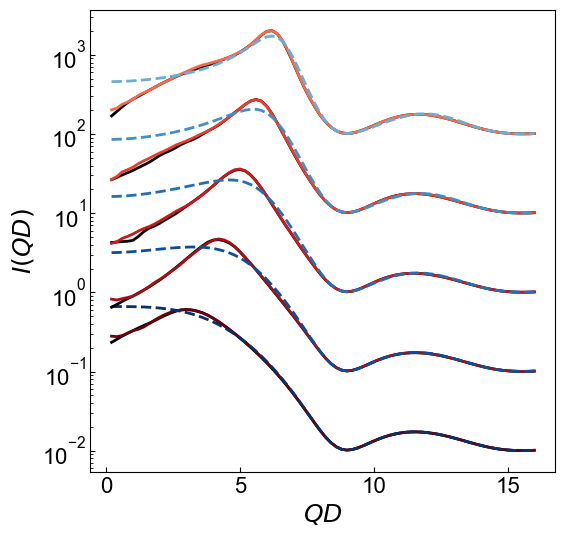

In [28]:
fig = plt.figure(figsize=(6, 6))#,dpi=192)
ax = plt.subplot(1, 1, 1)


for i in range(len(parameters_list)):
    fp_GT = dict_eta['fp_GT_list'][i]
    SQ_exp_GT = dict_eta['SQ_exp_GT_list'][i]
    
    r = (1-(fp_GT[0]-eta_list[0])/(eta_list[-1]-eta_list[0]))*0.5+0.5
    c_NN = cmap_NN(r)
    c_RMSA = cmap_RMSA(r)
    
    IQ_exp_GT = IQ_exp(SQ_exp_GT,fp_GT)*10**i
    IQ_exp_NN = IQ_th(SQ_NN,fp_GT)*10**i
    IQ_exp_RMSA = IQ_th(SQ_RMSA,fp_GT)*10**i

    ax.plot(q,IQ_exp_GT,
            '-k', lw=2, label='ground truth')
    ax.plot(q,IQ_exp_NN,
            '-', lw=2, label='NN', color=c_NN)
    ax.plot(q,IQ_exp_RMSA,
            '--', lw=2, label='RMSA', color=c_RMSA)

ax.set_xlabel(r'$QD$',fontsize=18)
ax.set_ylabel(r'$I(QD)$',fontsize=18)
ax.tick_params(direction='in', axis='both', which='both', labelsize=16)
ax.set_yscale('log')

plt.show()

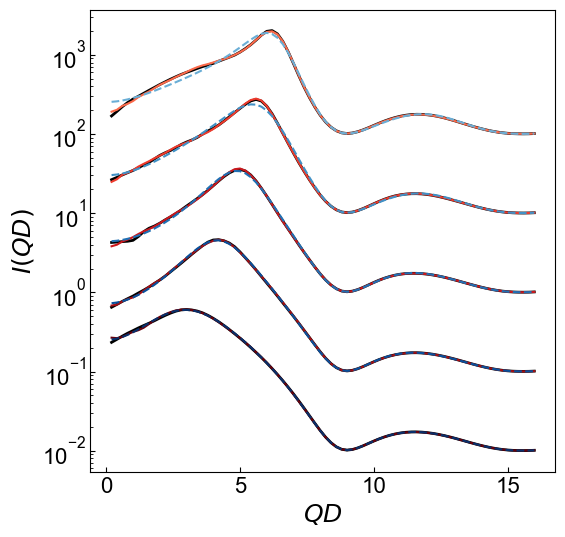

In [29]:
fig = plt.figure(figsize=(6, 6))#,dpi=192)
ax = plt.subplot(1, 1, 1)

for i in range(len(parameters_list)):
    fp_GT = dict_eta['fp_GT_list'][i]
    IQ_exp_GT = dict_eta['IQ_exp_GT_list'][i]
    fp_opt_NN = dict_eta['fp_opt_NN_list'][i]
    fp_opt_RMSA = dict_eta['fp_opt_RMSA_list'][i]
    
    r = (1-(fp_GT[0]-eta_list[0])/(eta_list[-1]-eta_list[0]))*0.5+0.5
    c_NN = cmap_NN(r)
    c_RMSA = cmap_RMSA(r)
    
    ax.plot(q,IQ_exp_GT*10**i,'-k',lw=2,
            label='ground truth')
    ax.plot(q,IQ_th(SQ_NN,fp_opt_NN)*10**i,'-',
            label='NN', color=c_NN)
    ax.plot(q,IQ_th(SQ_RMSA,fp_opt_RMSA)*10**i,'--',
            label='RMSA', color=c_RMSA)

    ax.set_yscale('log')
#     ax.legend(fontsize=16,frameon=False,fancybox=False)

ax.set_xlabel(r'$QD$',fontsize=18)
ax.set_ylabel(r'$I(QD)$',fontsize=18)
ax.tick_params(direction='in', axis='both', which='both', labelsize=16)

plt.show()

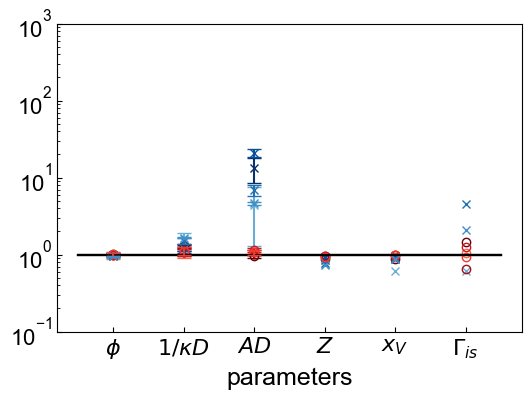

In [30]:
fig = plt.figure(figsize=(6, 4))#,dpi=192)

for i in range(len(parameters_list)):
    ax = plt.subplot(1, 1, 1)
    
    r = (1-(fp_GT[0]-eta_list[0])/(eta_list[-1]-eta_list[0]))*0.5+0.5
    c_NN = cmap_NN(r)
    c_RMSA = cmap_RMSA(r)
    
    fp_GT = dict_eta['fp_GT_list'][i]
    fp_opt_NN = dict_eta['fp_opt_NN_list'][i]
    fp_opt_RMSA = dict_eta['fp_opt_RMSA_list'][i]
    fp_err_NN = dict_eta['fp_err_NN_list'][i]
    fp_err_RMSA = dict_eta['fp_err_RMSA_list'][i]
    
#     index = np.r_[index_free,6,7,8]
    index = [0,1,2,6,7,8]
    ax.plot(fp_opt_NN[index]/fp_GT[index],'o', fillstyle='none',
            label='NN', color=c_NN)
    ax.plot(fp_opt_RMSA[index]/fp_GT[index],'x',
            label='RMSA', color=c_RMSA)
    ax.plot([-0.5,len(index)-0.5],[1,1],'-k')
    
    index_err = [0,1,2]
    ax.errorbar(np.arange(len(index_err)),fp_opt_NN[index_err]/fp_GT[index_err], fp_err_NN[index_err]/fp_GT[index_err],
           fmt='none',color=c_NN,capsize=5.0)
    ax.errorbar(np.arange(len(index_err)),fp_opt_RMSA[index_err]/fp_GT[index_err], fp_err_RMSA[index_err]/fp_GT[index_err],
           fmt='none',color=c_RMSA,capsize=5.0)

    ax.set_yscale('log')
#     ax.legend(fontsize=16,frameon=False,fancybox=False)
    ax.set_ylim([1e-1,1e3])
    
    tick_labels = [r'$\phi$',r'$1/\kappa D$',r'$AD$',r'$\sigma$',r'$C$',r'$I_{\it{inc}}$',
                   r'$Z$',r'$x_{V}$',r'$\Gamma_{is}$']
    ax.set_xticks(np.arange(len(index)))
    ax.set_xticklabels([tick_labels[it] for it in index])

    ax.set_xlabel('parameters',fontsize=18)
#     ax.set_ylabel(r'$I(QD)$',fontsize=18)
    ax.tick_params(direction='in', axis='both', which='both', labelsize=16)

plt.show()

## kappa

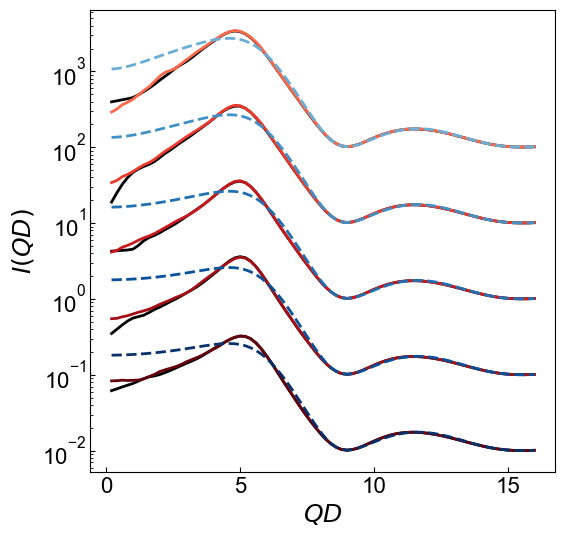

In [31]:
fig = plt.figure(figsize=(6, 6))#,dpi=192)
ax = plt.subplot(1, 1, 1)

for i in range(len(parameters_list)):
    fp_GT = dict_kappa['fp_GT_list'][i]
    SQ_exp_GT = dict_kappa['SQ_exp_GT_list'][i]
    
    r = (1-(fp_GT[1]-kappa_list[0])/(kappa_list[-1]-kappa_list[0]))*0.5+0.5
    c_NN = cmap_NN(r)
    c_RMSA = cmap_RMSA(r)
    
    IQ_exp_GT = IQ_exp(SQ_exp_GT,fp_GT)*10**i
    IQ_exp_NN = IQ_th(SQ_NN,fp_GT)*10**i
    IQ_exp_RMSA = IQ_th(SQ_RMSA,fp_GT)*10**i

    ax.plot(q,IQ_exp_GT,
            '-k', lw=2, label='ground truth')
    ax.plot(q,IQ_exp_NN,
            '-', lw=2, label='NN', color=c_NN)
    ax.plot(q,IQ_exp_RMSA,
            '--', lw=2, label='RMSA', color=c_RMSA)


ax.set_xlabel(r'$QD$',fontsize=18)
ax.set_ylabel(r'$I(QD)$',fontsize=18)
ax.tick_params(direction='in', axis='both', which='both', labelsize=16)
ax.set_yscale('log')

plt.show()

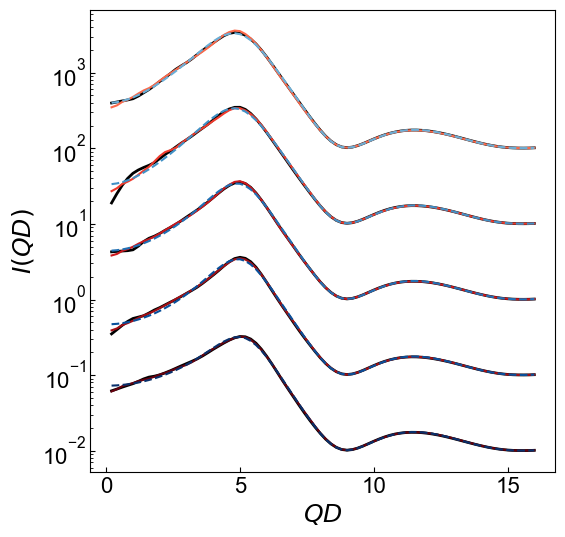

In [32]:
fig = plt.figure(figsize=(6, 6))#,dpi=192)
ax = plt.subplot(1, 1, 1)

for i in range(len(parameters_list)):
    fp_GT = dict_kappa['fp_GT_list'][i]
    IQ_exp_GT = dict_kappa['IQ_exp_GT_list'][i]
    fp_opt_NN = dict_kappa['fp_opt_NN_list'][i]
    fp_opt_RMSA = dict_kappa['fp_opt_RMSA_list'][i]
    
    r = (1-(fp_GT[1]-kappa_list[0])/(kappa_list[-1]-kappa_list[0]))*0.5+0.5
    c_NN = cmap_NN(r)
    c_RMSA = cmap_RMSA(r)
    
    ax.plot(q,IQ_exp_GT*10**i,'-k',lw=2,
            label='ground truth')
    ax.plot(q,IQ_th(SQ_NN,fp_opt_NN)*10**i,'-',
            label='NN', color=c_NN)
    ax.plot(q,IQ_th(SQ_RMSA,fp_opt_RMSA)*10**i,'--',
            label='RMSA', color=c_RMSA)

    ax.set_yscale('log')
#     ax.legend(fontsize=16,frameon=False,fancybox=False)

ax.set_xlabel(r'$QD$',fontsize=18)
ax.set_ylabel(r'$I(QD)$',fontsize=18)
ax.tick_params(direction='in', axis='both', which='both', labelsize=16)

plt.show()

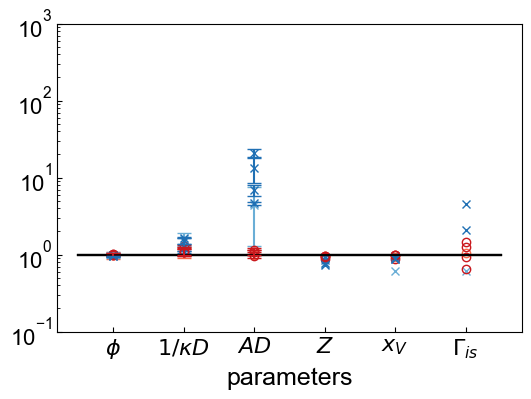

In [33]:
fig = plt.figure(figsize=(6, 4))#,dpi=192)

for i in range(len(parameters_list)):
    ax = plt.subplot(1, 1, 1)
    
    r = (1-(fp_GT[1]-kappa_list[0])/(kappa_list[-1]-kappa_list[0]))*0.5+0.5
    c_NN = cmap_NN(r)
    c_RMSA = cmap_RMSA(r)
    
    fp_GT = dict_eta['fp_GT_list'][i]
    fp_opt_NN = dict_eta['fp_opt_NN_list'][i]
    fp_opt_RMSA = dict_eta['fp_opt_RMSA_list'][i]
    fp_err_NN = dict_eta['fp_err_NN_list'][i]
    fp_err_RMSA = dict_eta['fp_err_RMSA_list'][i]
    
#     index = np.r_[index_free,6,7,8]
    index = [0,1,2,6,7,8]
    ax.plot(fp_opt_NN[index]/fp_GT[index],'o', fillstyle='none',
            label='NN', color=c_NN)
    ax.plot(fp_opt_RMSA[index]/fp_GT[index],'x',
            label='RMSA', color=c_RMSA)
    ax.plot([-0.5,len(index)-0.5],[1,1],'-k')
    
    index_err = [0,1,2]
    ax.errorbar(np.arange(len(index_err)),fp_opt_NN[index_err]/fp_GT[index_err], fp_err_NN[index_err]/fp_GT[index_err],
           fmt='none',color=c_NN,capsize=5.0)
    ax.errorbar(np.arange(len(index_err)),fp_opt_RMSA[index_err]/fp_GT[index_err], fp_err_RMSA[index_err]/fp_GT[index_err],
           fmt='none',color=c_RMSA,capsize=5.0)

    ax.set_yscale('log')
#     ax.legend(fontsize=16,frameon=False,fancybox=False)
    ax.set_ylim([1e-1,1e3])
    
    tick_labels = [r'$\phi$',r'$1/\kappa D$',r'$AD$',r'$\sigma$',r'$C$',r'$I_{\it{inc}}$',
                   r'$Z$',r'$x_{V}$',r'$\Gamma_{is}$']
    ax.set_xticks(np.arange(len(index)))
    ax.set_xticklabels([tick_labels[it] for it in index])

    ax.set_xlabel('parameters',fontsize=18)
#     ax.set_ylabel(r'$I(QD)$',fontsize=18)
    ax.tick_params(direction='in', axis='both', which='both', labelsize=16)

plt.show()

## A

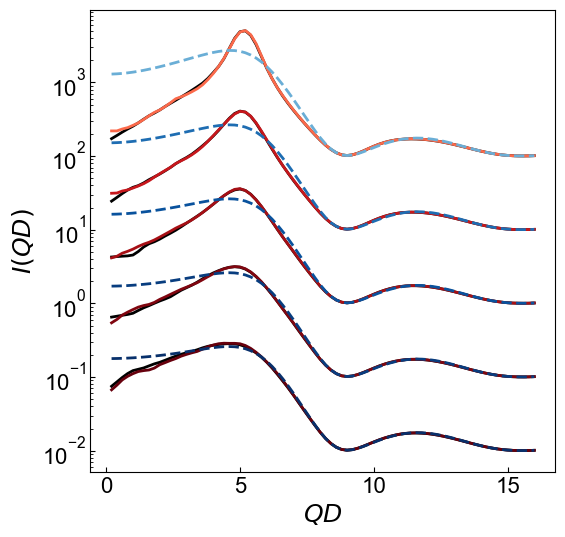

In [34]:
fig = plt.figure(figsize=(6, 6))#,dpi=192)
ax = plt.subplot(1, 1, 1)

for i in range(len(parameters_list)):
    fp_GT = dict_A['fp_GT_list'][i]
    SQ_exp_GT = dict_A['SQ_exp_GT_list'][i]
    
    r = (1-(fp_GT[2]-A_list[0])/(A_list[-1]-A_list[0]))*0.5+0.5
    c_NN = cmap_NN(r)
    c_RMSA = cmap_RMSA(r)
    
    IQ_exp_GT = IQ_exp(SQ_exp_GT,fp_GT)*10**i
    IQ_exp_NN = IQ_th(SQ_NN,fp_GT)*10**i
    IQ_exp_RMSA = IQ_th(SQ_RMSA,fp_GT)*10**i

    ax.plot(q,IQ_exp_GT,
            '-k', lw=2, label='ground truth')
    ax.plot(q,IQ_exp_NN,
            '-', lw=2, label='NN', color=c_NN)
    ax.plot(q,IQ_exp_RMSA,
            '--', lw=2, label='RMSA', color=c_RMSA)

ax.set_xlabel(r'$QD$',fontsize=18)
ax.set_ylabel(r'$I(QD)$',fontsize=18)
ax.tick_params(direction='in', axis='both', which='both', labelsize=16)
ax.set_yscale('log')

plt.show()

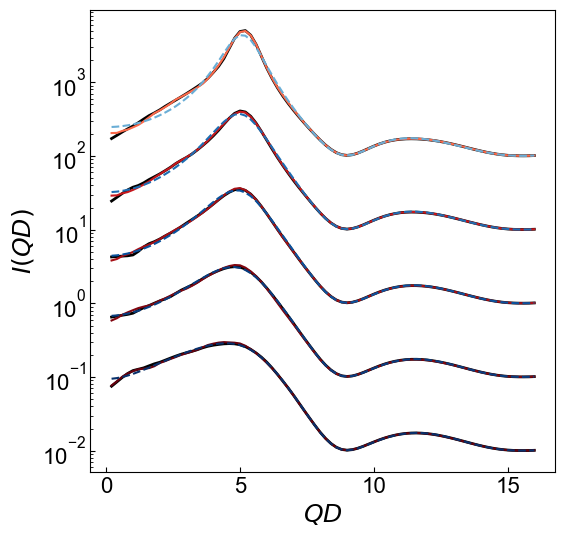

In [35]:
fig = plt.figure(figsize=(6, 6))#,dpi=192)
ax = plt.subplot(1, 1, 1)

for i in range(len(parameters_list)):
    fp_GT = dict_A['fp_GT_list'][i]
    IQ_exp_GT = dict_A['IQ_exp_GT_list'][i]
    fp_opt_NN = dict_A['fp_opt_NN_list'][i]
    fp_opt_RMSA = dict_A['fp_opt_RMSA_list'][i]
    
    r = (1-(fp_GT[2]-A_list[0])/(A_list[-1]-A_list[0]))*0.5+0.5
    c_NN = cmap_NN(r)
    c_RMSA = cmap_RMSA(r)
    
    ax.plot(q,IQ_exp_GT*10**i,'-k',lw=2,
            label='ground truth')
    ax.plot(q,IQ_th(SQ_NN,fp_opt_NN)*10**i,'-',
            label='NN', color=c_NN)
    ax.plot(q,IQ_th(SQ_RMSA,fp_opt_RMSA)*10**i,'--',
            label='RMSA', color=c_RMSA)

    ax.set_yscale('log')
#     ax.legend(fontsize=16,frameon=False,fancybox=False)

ax.set_xlabel(r'$QD$',fontsize=18)
ax.set_ylabel(r'$I(QD)$',fontsize=18)
ax.tick_params(direction='in', axis='both', which='both', labelsize=16)

plt.show()

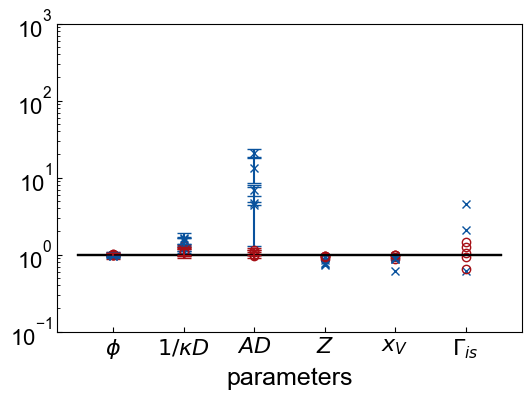

In [39]:
fig = plt.figure(figsize=(6, 4))#,dpi=192)
ax = plt.subplot(1, 1, 1)

for i in range(len(parameters_list)):

    r = (1-(fp_GT[2]-A_list[0])/(A_list[-1]-A_list[0]))*0.5+0.5
    c_NN = cmap_NN(r)
    c_RMSA = cmap_RMSA(r)
    
    fp_GT = dict_eta['fp_GT_list'][i]
    fp_opt_NN = dict_eta['fp_opt_NN_list'][i]
    fp_opt_RMSA = dict_eta['fp_opt_RMSA_list'][i]
    fp_err_NN = dict_eta['fp_err_NN_list'][i]
    fp_err_RMSA = dict_eta['fp_err_RMSA_list'][i]
    
#     index = np.r_[index_free,6,7,8]
    index = [0,1,2,6,7,8]
    ax.plot(fp_opt_NN[index]/fp_GT[index],'o', fillstyle='none',
            label='NN', color=c_NN)
    ax.plot(fp_opt_RMSA[index]/fp_GT[index],'x',
            label='RMSA', color=c_RMSA)
    ax.plot([-0.5,len(index)-0.5],[1,1],'-k')
    
    index_err = [0,1,2]
    ax.errorbar(np.arange(len(index_err)),fp_opt_NN[index_err]/fp_GT[index_err], fp_err_NN[index_err]/fp_GT[index_err],
           fmt='none',color=c_NN,capsize=5.0)
    ax.errorbar(np.arange(len(index_err)),fp_opt_RMSA[index_err]/fp_GT[index_err], fp_err_RMSA[index_err]/fp_GT[index_err],
           fmt='none',color=c_RMSA,capsize=5.0)

    ax.set_yscale('log')
#     ax.legend(fontsize=16,frameon=False,fancybox=False)
    ax.set_ylim([1e-1,1e3])
    
    tick_labels = [r'$\phi$',r'$1/\kappa D$',r'$AD$',r'$\sigma$',r'$C$',r'$I_{\it{inc}}$',
                   r'$Z$',r'$x_{V}$',r'$\Gamma_{is}$']
    ax.set_xticks(np.arange(len(index)))
    ax.set_xticklabels([tick_labels[it] for it in index])

    ax.set_xlabel('parameters',fontsize=18)
#     ax.set_ylabel(r'$I(QD)$',fontsize=18)
    ax.tick_params(direction='in', axis='both', which='both', labelsize=16)

plt.show()

In [37]:
opti_NN

      fun: 0.0007543635888936989
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([7.14074230e-06, 1.92435189e-04, 2.78784258e-05, 7.06940674e-08])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 126
      nit: 8
     njev: 14
   status: 0
  success: True
        x: array([ 0.22614239,  0.33820372, 19.9998512 ,  0.99734391])